## Ballistic Missile Defence: A Primer
___

The objective of this project is to illustrate some of the fundamental concepts of ballistic missile defense (BMD). The goal is not to provide 
mathematically accurate models of the ways BMD systems operate, but to provide some intuition behind the theories and assumptions underlying 
missile defence.

In [2]:
# Import packages
using LinearAlgebra, NLsolve, LaTeXStrings, Plots, PlotThemes
theme(:default)

## Terminal Defence

The most basic form of ballistic missile defence is terminal defence. Simply put, this entails intercepting incoming warheads during their "terminal" phase, 
or when they have re-entered the atmosphere. Terminal defence is usually used for "point defence", or a deployment intended to defend specific targets such as 
ICBM silos or cities. Systems designed for terminal intercepts include Patriot PAC-3 and Terminal High Altitude Area Defense (THAAD), which have been a 
mainstay of U.S. missile defence architecture for decades. Due to their simplicity, terminal BMD systems offer a nice starting point for illustrating 
some of the guiding logic of missile defence.

![MIM-104D PAC-2 launching a GEM missile during a test](./assets/pac2_gem.jpg)

### Basic Setup

Let $x$ be the number of re-entry vehicles (RVs) constituting an attack. Furthermore, let $\pi_x: \mathbb{R^+} \to [0,1]$ be a function which defines the 
probability of intercept for a specific attack size $x$.

Assume that the efficiency of the terminal BMD system experiences some small decay, $\alpha$, as the number of RVs increases. For limited-scale 
attacks with low numbers of RVs, the BMD system is capable of performing at or near its theoretical efficiency. However, for larger attacks involving 
hundreds of RVs or more, intercept probability can decrease for the following reasons:

- Airburst detonations causing temporary radar blackouts, thus making tracking and discrimination of incoming RVs more difficult

- Strikes against C3 nodes severing communications links between BMD radars and interceptor launch stations

- "Shoot-look-shoot" strategies allowing follow-on warheads to be targeted on areas not in the area of coverage of a BMD system

As such, we have a sequence of intercept probabilities defined by the following process:

$$
\begin{aligned}
\pi_x &= \alpha\pi_{x-1}
\end{aligned}
$$

Where $|\alpha| < 1$. However, by iterating backwards we have

$$
\begin{aligned}
\pi_x &= \alpha\pi_{x-1} \\
&= \alpha(\alpha\pi_{x-2}) \\
& \;\;\vdots \notag \\
& = \alpha^x\pi_0
\end{aligned}
$$

And so we can write this as a function rather than an iterative process.

### Simulations

In [5]:
mutable struct terminal
    init::Float64
    kill::Float64
    alpha::Float64
    rv::Int64
end

# parameters for example simulation
p_t = terminal(0.8, 0.9, 0.999, 1000)

terminal(0.8, 0.9, 0.999, 1000)

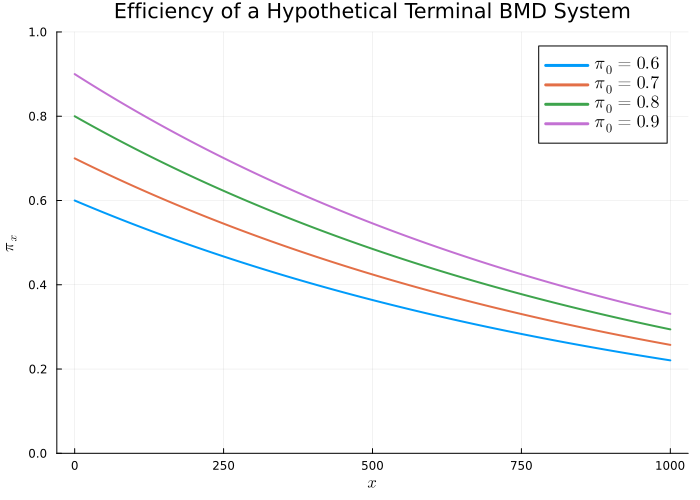

In [3]:
function terminal_prob(pi_0, alpha, rv)
    # create probability arrays 
    pi_x = zeros(rv + 1)
    pi_x[1] = pi_0
    
    # iterate probabilities over x
    for i in 2:(rv + 1)
        pi_x[i] = alpha * pi_x[i - 1]
    end
    return pi_x
end

# plot intercept probabilities
plt_1 = plot(legendfontsize = 12, ylimits = (0, 1), size = (700, 500),
             title = "Efficiency of a Hypothetical Terminal BMD System")
probs = [0.6, 0.7, 0.8, 0.9]

for p_t.init in probs
    label = p_t.init
    plot!(plt_1, 0:p_t.rv, terminal_prob(p_t.init, p_t.alpha, p_t.rv), lw = 2,
          xlabel = L"x", ylabel = L"\pi_x", label = L"\pi_0 = %$label")
end

plt_1

The chart above shows the evolution of $\pi(x)$ for $\pi_0 \in \{0.6, 0.7, 0.8, 0.9\}$. For limited scale attacks with relatively small 
numbers of re-entry vehicles, $\pi(x)$ is only slightly smaller than the initial value. However, as the number of RVs increases, intercept probability 
starts to decrease. At 500 RVs, $\pi(x)$ has already decreased by approximately 40%. This trend continues for increasingly larger attacks, where the BMD 
system struggles to intercept incoming warheads at a regular rate, regardless of the theoretical efficiency. Intuitively, this makes some sense, as 
discrimination is never perfect, and neither are the computer systems performing battle management and managing engagement sequences. For larger attacks 
in particular, these imperfections are magnified, and as a result, the terminal BMD system sees its intercept probability significantly reduced. Of course, 
one can tweak the parameters for more favourable performance, or to test different assumptions of likely parameter values, but the behaviour effectively 
remains the same, and we would expect to see similar patterns for different initial values.

How does the BMD system fare under different attack scenarios though? We can assess the rough performance by assessing how intercepts evolve with attack size.
Let $I_x$ denote the number of intercepts, and let $L_x$ denote leakage, i.e. how many warheads "leak" through, or fail to be intercepted by the BMD system.
We have the following expressions

$$I_x = x\pi(x)$$

$$L_x = x - I_x$$

At what point does the BMD system become overwhelmed by incoming warheads? A useful threshold is the point when leakage exceeds interceptions. Here, 
the probability of leakage $l(x)$ is denoted as $(1 - \pi(x))$. Rewriting $\pi(x)$ in terms of its previous value, and setting both sides equal to each
other means we have

$$
\begin{aligned}
f(x) &= l(x) - \pi(x) \\
&= (1 - \alpha^x\pi_0) - \alpha^x\pi_0 \\
&= 1 - 2\alpha^x\pi_0
\end{aligned}
$$

We can find the roots of this function using the `NLsolve` module in Julia. Using the same parameters outlined above, we can assess how the
defence performs, and how the interception trajectories evolve across $x$. Here, we consider the following parameters for a simulated 
terminal BMD system:

* $\pi_0 = 0.80$, which is an ambitious, but still feasible intercept probability

* $\alpha = 0.999$

* $x = [1, 1000]$, which covers the majority of attack scenarios aside from all-out exchanges

The code shown below implements a simulation of a terminal BMD system with the parameters defined above.

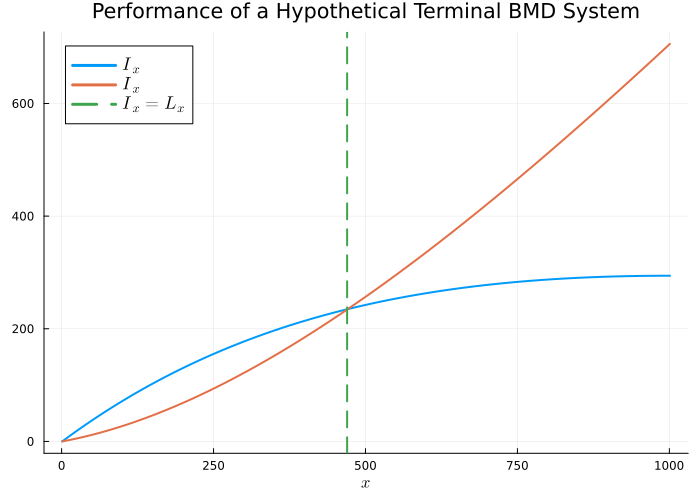

In [6]:
function terminal_perf(pi_0, alpha, rv)
    # get probabilities and calculate intercepts
    x = range(0, rv)
    pi_x = terminal_prob(pi_0, alpha, rv)
    I_x = pi_x .* x
    L_x = x .- I_x

    # define turning point function
    function f!(F, x)
        F[1] = 1 - (2 * pi_0) * alpha^x[1]
    end

    # store results
    sol = nlsolve(f!, [1.0])
    out = (; int = I_x, leak = L_x, sol = sol.zero)
    return out
end

simul_1 = terminal_perf(p_t.init, p_t.alpha, p_t.rv)

plt_2 = plot(legendfontsize = 12, size = (700, 500), 
             title = "Performance of a Hypothetical Terminal BMD System")
plot!(plt_2, simul_1.int, lw = 2, xlabel = L"x", label = L"I_x")
plot!(plt_2, simul_1.leak, lw = 2, label = L"I_x")
vline!(plt_2, [simul_1.sol], lw = 2, ls = :dash, label = L"I_x = L_x")

plt_2

The above chart shows how the defence performs over a range of possible attack scenarios. The terminal BMD system manages 
to perform admirably, but only for smaller-scale attacks. After attack size exceeds 250 RVs, intercept probability starts to decline and leakage begins to 
increase at a faster rate. The threshold for efficiency is reached at approximately 470 RVs, when $I_x = L_x$. After this point, more warheads 
penetrate the defences than the defences can manage to successfully intercept, and the defences get swamped. At the upper bounds, with 
a 1,000 RV attack, only one-third of the warheads are intercepted while the rest pass through and detonate on their targets. Under such a large 
attack, it is reasonable to expect impairment of sensors providing information to BMD launch stations and disruptions of communications more 
generally, especially since C3 nodes themselves may be targeted in large counterforce attacks. Though a simple example, it illustrates the challenges 
that terminal defence systems would face in a nuclear exchange.

___

## Layered Defence

The second, and most notable form of ballistic missile defence is layered defence, which consists of multiple "layers" operating independently and 
designed to intercept ballistic missiles during different phases of flight. One layer might be designed for exoatmospheric interceptions of 
ballistic missiles before RVs can be deployed, while another layer might be responsible for handling interceptions somewhere between the 
midcourse and terminal phase. Taken together, layered defence is intended to provide more reliable and more consistent intercepts of adversary 
warheads than a terminal system operating alone. 

![Constituent Layers of U.S. BMD Architecture](./assets/bmd_layers.png)

The picture above shows the constituent layers of current U.S. missile defence architecture, and also provides a good illustration of how layered defence
works more generally. In order for a missile to reach some sort of target, it must successfully evade three different defence layers consecutively. Where 
an intercept fails, successive attempts at intercepting an attacking warhead can be made in successive layers, each with its own probability of scoring an intercept. 
Since the layers operate independently of each other (they may benefit from shared radar/sensors though), the probability that a projectile is intercepted by *at least* 
one layer is much higher than the intercept probability of a single-layer terminal system. In turn, this makes layered defence systems particularly 
attractive, as they mititage the risks of a terminal-only BMD system. Different layers can also be tuned to handle different types of missile threats (e.g. THAAD for tactical ballistic missiles, GMD for ICBMs).

### Setup

Let $\pi_{1,x}: \mathbb{R}^+ \to [0,1]$ be a function defining the intercept probabilities of a BMD overlay, and let $\pi_{2,x}: \mathbb{R}^+ \to [0,1]$
be a function defining the intercept probability of a BMD underlay. As before, assume some decay $\alpha$ as the number of warheads increaes.

We then have following sequences of probabilities

$$
\begin{aligned}
\pi_{1,x} &= \alpha \pi_{1,x-1} \\
&= \alpha^x\pi_1 \\
& \\
\pi_{2,x} &= \alpha \pi_{2,x-1} \\
&= \alpha^x\pi_2
\end{aligned}
$$

Let $l_1$ and $l_2$ define the leakage, i.e. the probability a warhead evades a particular layer of the BMD system. We then have

$$l_{1,x} = (1 - \pi_{1,x})$$
$$l_{2,x} = (1 - \pi_{2,x})$$

Since both layers operate independently, the probability of leakage in both layers is given by

$$
\begin{aligned}
l_x &= l_{1,x} \cdot l_{2,x} \\
&= (1 - \pi_{1,x}) \cdot (1 - \pi_{2,x})
\end{aligned}
$$

And total intercept probability is

$$
\begin{aligned}
\pi_x = 1 - l_x
\end{aligned}
$$

### Simulations

In [8]:
mutable struct layered
    init1::Float64
    init2::Float64
    kill::Float64
    alpha::Float64
    rv::Int64
end

p_l = layered(0.8, 0.8, 0.9, 0.999, 2000)

layered(0.8, 0.8, 0.9, 0.999, 2000)

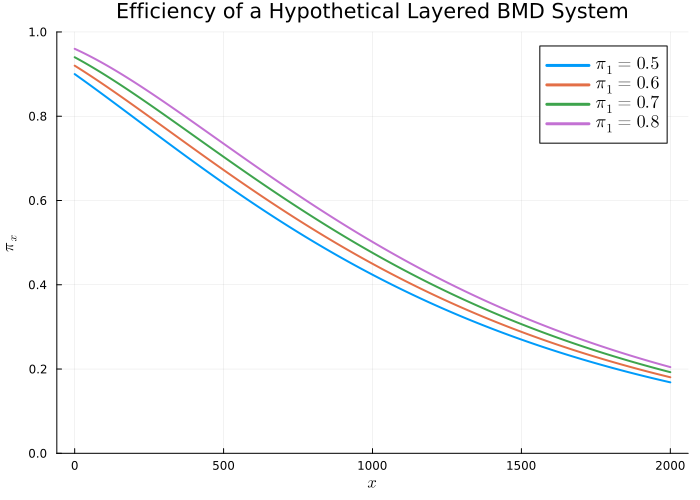

In [9]:
function layered_prob(pi_1, pi_2, alpha, rv)
    # create probability arrays
    pi_1x = zeros(rv + 1)
    pi_2x = zeros(rv + 1)
    pi_1x[1] = pi_1
    pi_2x[1] = pi_2

    # iterate probabilities over x
    for i in 2:(rv + 1)
        pi_1x[i] = alpha * pi_1x[i - 1] 
        pi_2x[i] = alpha * pi_2x[i - 1]
    end
        
    pi_x = 1 .- (1 .- pi_1x) .* (1 .- pi_2x)
    return pi_x    
end

plt_3 = plot(legendfontsize = 12, ylimits = (0, 1), size = (700, 500),
             title = "Efficiency of a Hypothetical Layered BMD System")
probs = [0.5, 0.6, 0.7, 0.8]

for p_l.init1 in probs
    label = p_l.init1
    plot!(plt_3, 0:p_l.rv, layered_prob(p_l.init1, 0.8, p_l.alpha, p_l.rv), lw = 2,
          xlabel = L"x", ylabel = L"\pi_x", label = L"\pi_1 = %$label")
end

plt_3

The chart above shows the evolution of $\pi_x$ for $\pi_1 \in \{0.5, 0.6, 0.7, 0.8\}$ and $\pi_2$ held constant at $0.8$. Because intercept probabilities are compounded due to each layer operating independently of the other, we see a slower decline in efficiency as opposed to the single-layer terminal system. With the underlay efficiency $(\pi_2)$ held constant, there also isn't too much of a difference in performance between different initial overlay probabilities $(\pi_1)$, as evidenced by the tighter spacing between each function. By the time an attack size reaches 2,000 RVs, $\pi_x$ has pretty much converged to same value of 0.2 regardless of the efficiency of the first layer in the defence. It's reasonable to assume that by then, under such a large attack, no BMD system would be able to reliably score intercepts, as the severity of an all-out exchange would damage or destroy warning sensors and communications links in a way that would leave the system capable of intercepting little more than the occasional warhead.

How does the layered BMD system stack up under different attacks? As before, we can look for the point where leakage exceeds interceptions. Like before,
we can define $l(x)$ and $\pi(x)$ and set both functions equal to each other.

$$
\begin{aligned}
f(x) &= l(x) - \pi(x) \\
&= (1 - \alpha^x\pi_{1})(1 - \alpha^x\pi_{2}) - [1 - (1 - \alpha^x\pi_{1})(1 - \alpha^x\pi_{2})] \\
&= (1 - \alpha^x\pi_{1} - \alpha^x\pi_{2} + \alpha^{2x}\pi_{1}\pi_{2}) - \alpha^x\pi_{1} - \alpha^x\pi_{2} + \alpha^{2x}\pi_{1}\pi_{2} \\
&= 1 - 2\alpha^x\pi_{1} - 2\alpha^x\pi_{2} + 2\alpha^{2x}\pi_{1}\pi_{2}
\end{aligned}
$$

Solving for $f(x) = 0$ gives the "turning point", or when leakage begins to exceed the number of intercepts scored by the BMD system. Again,
this can be used to chart the performance of the defence across different attack scenarios. Here, we consider the following parameters for a simulated
layered BMD system:

* $\pi_{1,x} = 0.8$

* $\pi_{2,x} = 0.8$

* $\alpha = 0.999$

* $x = [1, 2000]$

The code below implements a simulation of layered defence with the parameters defined above.

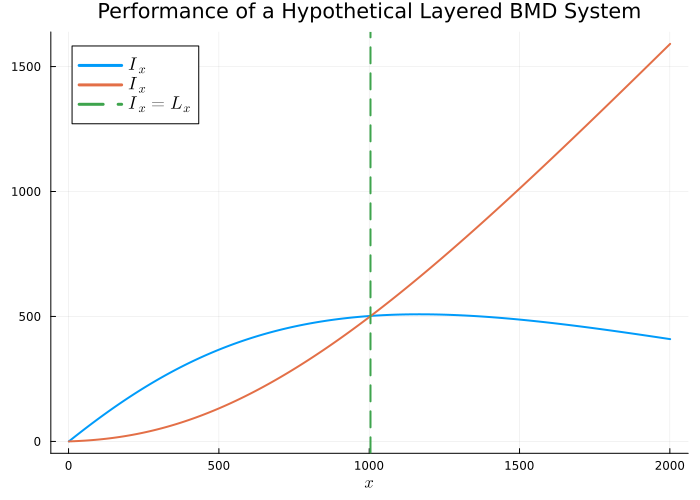

In [10]:
function layered_perf(pi_1, pi_2, alpha, rv)
    # get probabilities and calculate intercepts
    x = range(0, rv)
    pi_x = layered_prob(pi_1, pi_2, alpha, rv)
    I_x = pi_x .* x
    L_x = x .- I_x

    # define turning point function
    function f!(F, x)
        F[1] = 1.0 - 2pi_1 * alpha^x[1] - 2pi_2 * alpha^x[1] + (2pi_1 * pi_2) * alpha^2x[1]
    end
    
    # store results
    sol = nlsolve(f!, [1.0])
    out = (; int = I_x, leak = L_x, sol = sol.zero)
    return out
end

simul_2 = layered_perf(p_l.init1, p_l.init2, p_l.alpha, p_l.rv)

plt_4 = plot(legendfontsize = 12, size = (700, 500),
             title = "Performance of a Hypothetical Layered BMD System")
plot!(plt_4, simul_2.int, lw = 2, xlabel = L"x", label = L"I_x")
plot!(plt_4, simul_2.leak, lw = 2, label = L"I_x")
vline!(plt_4, [simul_2.sol], lw = 2, ls = :dash, label = L"I_x = L_x")
plt_4

The chart above shows how a layered BMD system would possibly perform over the range of possible attack scenarios. For small-scale attacks, the layered defence performs exceptionally well, owing to each of its constituent layers effectively shoring up the efficiency of the other. During such a scenario, it's reasonable to assume that communications links and sensors supporting the BMD system aren't operating under too much pressure. The layered system also performs surprisingly well during higher intensity attacks. Although intercept probability starts to flatline at around 800 warheads, it still remains pretty reasonable. In a 1,000 warhead attack, the system manages to intercept roughtly half of them. The terminal system by contrast was barely capable of intercepting half of that at the same attack level. Here, the turning point is reached at approximately 1,000 RVs, when $I_x = L_x$. After this, intercepts slowly drop off, but not by much, and the system still holds up pretty well during an all-out exchange with 2,000 warheads raining down. In such an exchange, intercepting 400 warheads seems pretty admirable, though whether an *actual* layered system would be capable of this is a different question altogether. Though is a highly idealised defence setup, and one that is admittedly quite unrealistic, it does illustrate how effective simply adding another layer to a defence system can be.

___

### Target Survivability

By design, BMD systems are designed to protect some target, or set of targets, by intercepting missiles which would otherwise destroy them. How effective are both types of systems in maximising the number of targets that emerge from nuclear attack unscathed? The actual answer to this question varies wildly depending on what targeting schemes an adversary uses. For instance, one can imagine 2-for-1 targeting being the tactic of choice, where the attacker assigns two warheads to each target of interest, hoping to maximise kill probability by subjecting the target to two independent detonations. "Shoot-look-shoot" tactics might well be another option, in which an attacker fires a fraction of their allocated missiles at a subset of targets, and fires the remaining missiles after assessing the effect of the initial salvo. For simplicity though, and for the purposes of being illustrative, assume that a single warhead is assigned to any target i.e. 1-on-1 targeting.

Let $\pi_k$ denote the kill probability i.e. the probability that a warhead manages to successfully destroy a target. Then targets killed are given by the function

$$T(x; \pi) = x \cdot (1 - \pi_x) \cdot \pi_k$$

For illustrative purposes, the following assumptions apply:

- $\pi_k = 0.9$, which is generally accepted as an accurate estimate of the kill probability of modern warheads and frequently used as a baseline in related literature

- $\alpha = 1$, meaning no decay

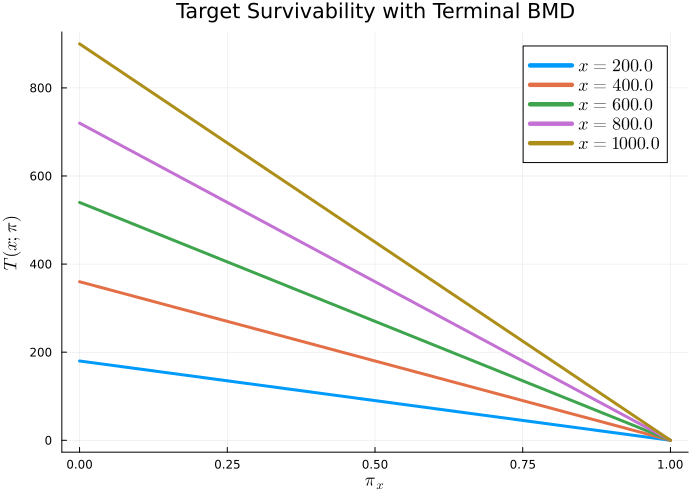

In [66]:
function terminal_surv(pi_k, rv_max, alpha)
    pi = range(0, 1, 100)
    rv = range(rv_max / 5, rv_max, 5)
    plt = plot(guidefontsize = 12, legendfontsize = 12, 
            size = (700, 500))

    for x in rv
        L_x = x .* (1 .- pi)
        T_k = pi_k .* L_x
        plot!(plt, pi, T_k, label = L"x = %$x", lw = 3,
              xlabel = L"\pi_x", ylabel = L"T(x;\pi)",
              title = "Target Survivability with Terminal BMD")
    end
    return plt
end

terminal_surv(p_t.kill, p_t.rv, 0.999)

The chart above plots target survivability as a function of intercept probability (denoted $T(x; \pi)$), mapped out for five different attack scenarios. The patterns 
here are pretty predictable. Lower values of $\pi_x$ are almost useless at protecting targets, and the ratio of targets killed to RVs is close to the kill probability $\pi_k$. As $\pi_k$ increases, and the BMD system increases in efficiency, the fraction of targets killed relative to warheads slowly declines. Although the decay in intercept probability as $x$ increases has a dampening effect, higher values of $\pi_x$ are able to absorb increases in attack sizes pretty well without sacrificing too many targets. When $\pi_x = 0.75$, doubling the number of warheads from 200 to 400 only results in an additional 50 targets being killed.

As usual, the behaviour of $T(\pi)$ depends on the assumed parameter values, but we should expect to see similar patterns regardless of what the specific kill probability or decay are like.

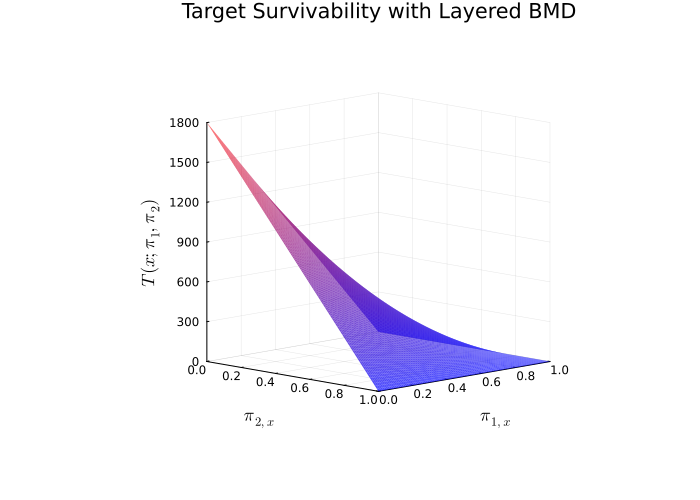

In [68]:
function layered_surv(pi_k, rv_max, alpha)
    pi_1 = range(0, 1, 100)
    pi_2 = range(0, 1, 100)
    x = rv_max
    plt = plot(guidefontsize = 12, size = (700, 500))

    T_k(pi_1, pi_2) = x .* (1 .- pi_1) .* (1 .- pi_2) .* pi_k
    plot!(plt, pi_1, pi_2, T_k, st = :surface, c = cgrad([:blue, :red]),
          alpha = 0.7, label = "Targets Killed", xlabel = L"$\pi_{2,x}$",
          ylabel = L"$\pi_{1,x}$", zlabel = L"T(x;\pi_1, \pi_2)", colorbar = false, 
          camera = (45, 10), title = "Target Survivability with Layered BMD")
end

layered_surv(p_l.kill, p_l.rv, p_l.alpha)

In the case of a layered BMD system, target survivability is represented by a multivariate surface rather than a one-dimensional function, owing to each layer in the defence having its own independent intercept probability. The chart above shows $T(x; \pi_{1}, \pi_{2})$ plotted for a 2,000 warhead attack. Holding constant the probability of one layer, we see similar behaviour to the terminal system, where target kill drops off in a linear fashion as the performance of the other layer gets better. The survivability function here also displays a convex surface away from its axes. Due to both intercept probabilities compounding, the slope gradually decreases as $\pi_1, pi_2$ both increase. As seen in the chart, increases in both past a certain point only result in marginal improvements in target survivability. For this particular attack scenario, $T(0.6, 0.6)$ doesn't really differ much from $T(0.6, 0.8)$ in terms of how many targets wind up being killed. Even $T(0.8, 0.8)$ seems indistinguishable from $T(0.9,0.9)$. Although a highly stylized scenario, it does demonstrate that even the most well set-up missile defence systems might have an upper limit to their effectiveness.